# CNN
## Author : Manas Mahale <<manas.mahale@bcp.edu.in>>
---

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [2]:
EPOCH      = 1
BATCH_SIZE = 50

---
## Data

In [3]:
X_train = pd.read_pickle('./Data/processed/X_train.pkl').values
y_train = pd.read_pickle('./Data/processed/y_train.pkl').values
X_test  = pd.read_pickle('./Data/processed/X_test.pkl').values
y_test  = pd.read_pickle('./Data/processed/y_test.pkl').values

In [4]:
vocab = list(set(np.concatenate([list(i) for i in X_train])))

In [5]:
d = {}
for n, i in enumerate(vocab):
    zero = np.zeros(len(vocab))
    zero[n]=1
    d[i] = zero

In [6]:
def padded_one_hot_encode_smiles(smiles, pad_len = max([len(i) for i in X_train])):
    return np.array([d[smiles[i]] if i < len(smiles) else np.zeros(len(vocab)) for i in range(pad_len)])

In [7]:
X_val   = np.array([padded_one_hot_encode_smiles(i) for i in X_train[3000:3500]]).astype(np.float32)
X_train = np.array([padded_one_hot_encode_smiles(i) for i in X_train[:3000]]).astype(np.float32)
X_test  = np.array([padded_one_hot_encode_smiles(i) for i in X_test[:1000]]).astype(np.float32)

In [8]:
print("X_val shape   :", X_val.shape)
print("X_train shape :", X_train.shape)
print("X_test shape  :", X_test.shape)

X_val shape   : (500, 748, 46)
X_train shape : (3000, 748, 46)
X_test shape  : (1000, 748, 46)


In [9]:
y_val   = y_train[3000:3500]
y_train = y_train[:3000]
y_test  = y_test[:1000]

classes = ('drug', 'drug_like', 'non_drug')

In [10]:
print("y_val shape   :", y_val.shape)
print("y_train shape :", y_train.shape)
print("y_test shape  :", y_test.shape)

y_val shape   : (500,)
y_train shape : (3000,)
y_test shape  : (1000,)


In [11]:
train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

test_data = []
for i in range(len(X_test)):
    test_data.append([X_test[i], y_test[i]])

val_data = []
for i in range(len(X_val)):
    val_data.append([X_val[i], X_val[i]])

In [12]:
trainloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
test  = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
val   = DataLoader(val_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=8)

---
## Models

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(23552, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

---
## Train

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [15]:
total_loss = []

for epoch in range(1, EPOCH+1):
    print(f"Epoch {epoch}")
    print('='*10)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
# optimizer.zero_grad() this before and after loss.backward()
        optimizer.zero_grad()

        outputs = net(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_loss.append(running_loss)
        print(f'Batch:{i + 1}/{len(trainloader)} loss: {running_loss}')
        running_loss = 0.0
            
    print('-'*10)
    print(f"Epoch {epoch} Loss {running_loss}")
    print('-'*10)
    writer.flush()
    

writer.close()
print('Finished Training')

Epoch 1
Batch:1/60 loss: 2.280010461807251
Batch:2/60 loss: 7.881497383117676
Batch:3/60 loss: 5.7856855392456055
Batch:4/60 loss: 2.124044179916382
Batch:5/60 loss: 2.1869678497314453
Batch:6/60 loss: 2.152250289916992
Batch:7/60 loss: 2.103520631790161
Batch:8/60 loss: 2.0273854732513428
Batch:9/60 loss: 1.9338489770889282
Batch:10/60 loss: 1.8492077589035034
Batch:11/60 loss: 1.6472499370574951
Batch:12/60 loss: 1.499735713005066
Batch:13/60 loss: 1.3728889226913452
Batch:14/60 loss: 1.2901206016540527
Batch:15/60 loss: 1.1064091920852661
Batch:16/60 loss: 1.2407935857772827
Batch:17/60 loss: 1.0882853269577026
Batch:18/60 loss: 1.0054157972335815
Batch:19/60 loss: 0.9873601794242859
Batch:20/60 loss: 0.7551576495170593
Batch:21/60 loss: 1.1377102136611938
Batch:22/60 loss: 1.0464682579040527
Batch:23/60 loss: 0.9126550555229187
Batch:24/60 loss: 0.9983192682266235
Batch:25/60 loss: 1.1352959871292114
Batch:26/60 loss: 0.9473118782043457
Batch:27/60 loss: 0.946255087852478
Batch:28/

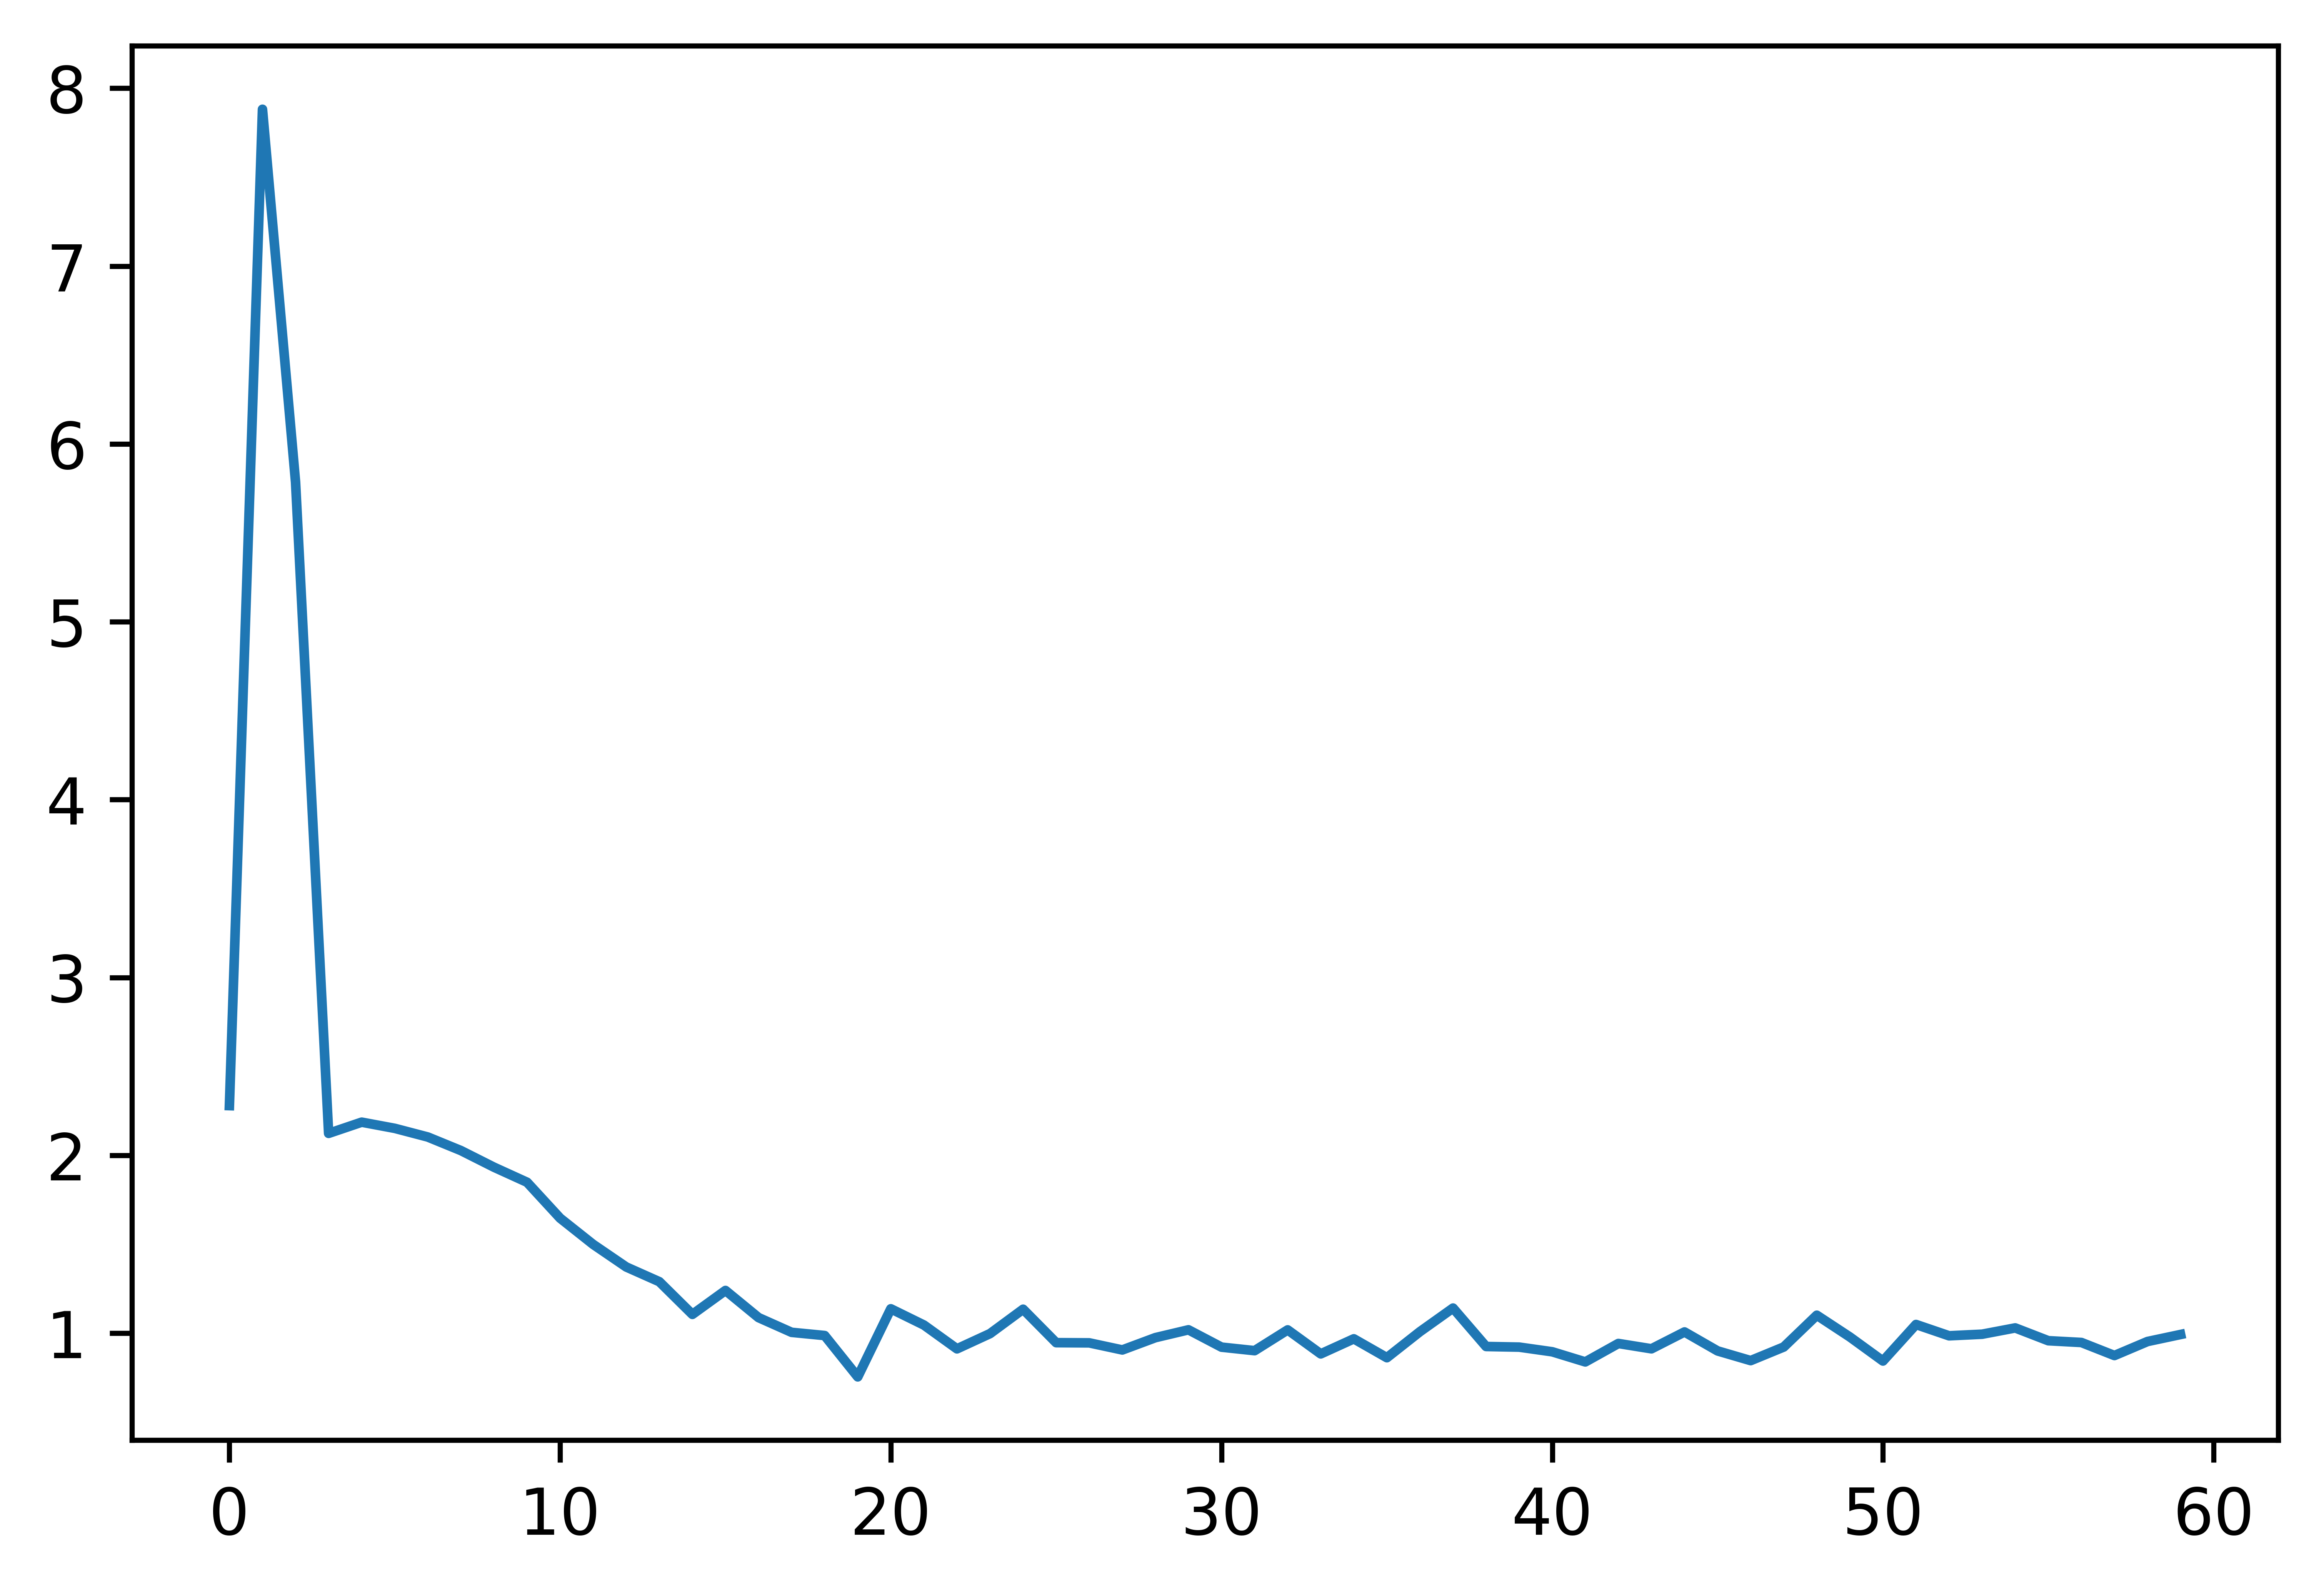

In [16]:
plt.figure(dpi=1200)
plt.plot(total_loss)

In [17]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6007/ (Press CTRL+C to quit)
^C


In [18]:
# PATH = './CNN.pth'
# torch.save(net.state_dict(), PATH)

In [19]:
# LOAD Model
# net = NeuralNetwork()
# net.load_state_dict(torch.load(PATH))

In [22]:
correct = 0
total = 0

with torch.no_grad():
    for data in test:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the testset: %d %%' % (
    100 * correct / total))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 5, 5], but got 3-dimensional input of size [50, 748, 46] instead

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))